In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(rc={'text.usetex' : True})

FAST_MODEL = True

CSV_DIR = '../gpu'
all_files = [os.path.join(CSV_DIR, file) for file in os.listdir(CSV_DIR)]
df_list = [pd.read_csv(file) for file in all_files]
df = pd.concat(df_list, ignore_index=True)

df = df.loc[df['3mm'] == FAST_MODEL]
df['rank_factor'] = df['rank_factor'].astype('category')
df['rank_factor'] = df['rank_factor'].cat.add_categories(['Original'])
df.loc[df['apply_tucker'] == False, 'rank_factor'] = 'Original'

df['device_name'] = df['device_name'].astype('category')
new_labels = {
    'NVIDIA GeForce RTX 3090': 'RTX 3090', 
    'NVIDIA GeForce GTX 1080': 'GTX 1080', 
    'NVIDIA A100-SXM4-40GB': 'A100', 
    'NVIDIA GeForce RTX 3060': 'RTX 3060', 
    'NVIDIA GeForce GTX 1660': 'GTX 1660', 
    'NVIDIA RTX A6000': 'A6000', 
    'GeForce RTX 2080 Ti': 'RTX 2080 Ti', 
    'NVIDIA GeForce RTX 2070 SUPER': 'RTX 2070 SUPER', 
}
df['device_name'] = df['device_name'].cat.rename_categories(new_labels)
new_order = ['GTX 1080', 'GTX 1660', 'RTX 2070 SUPER', 'RTX 2080 Ti', 'RTX 3060', 'RTX 3090', 'A6000', 'A100']
df['device_name'] = df['device_name'].cat.reorder_categories(new_order, ordered=True)

df.head()

,batch_size,device,load_params,apply_tucker,autocast,compile,eval_passes,ckpt_path,save_model,load_model,...,rank_mode,rank_factor,rank_min,decompose,verbose,g_flops,m_params,exec_time_mean,exec_time_std,device_name
0,1,cuda,False,True,True,True,10,.checkpoints/model.ckpt,False,False,...,relative,0.05,8,False,False,19.544361,0.151435,12.743056,0.117014,RTX 3090
2,1,cuda,False,True,True,False,10,.checkpoints/model.ckpt,False,False,...,relative,0.05,8,False,False,19.544361,0.151435,17.694096,0.094993,RTX 3090
4,1,cuda,False,True,False,True,10,.checkpoints/model.ckpt,False,False,...,relative,0.05,8,False,False,19.544361,0.151435,17.489190,0.097548,RTX 3090
6,1,cuda,False,True,False,False,10,.checkpoints/model.ckpt,False,False,...,relative,0.05,8,False,False,19.544361,0.151435,23.235347,0.021547,RTX 3090
8,1,cuda,False,False,True,True,10,.checkpoints/model.ckpt,False,False,...,relative,Original,8,False,False,369.144079,16.550518,22.564531,0.262672,RTX 3090


### GPU Variations

In [2]:
df['device_name'].unique()

['RTX 3090', 'GTX 1080', 'A100', 'RTX 3060', 'GTX 1660', 'A6000', 'RTX 2080 Ti', 'RTX 2070 SUPER']
Categories (8, object): ['GTX 1080' < 'GTX 1660' < 'RTX 2070 SUPER' < 'RTX 2080 Ti' < 'RTX 3060' < 'RTX 3090' < 'A6000' < 'A100']

### Maximum Batch Size

In [3]:
df_sub = df[df['compile'] == False]
df_batch = df_sub.groupby(['device_name', 'autocast', 'rank_factor'], observed=True)['batch_size'].max()
df_batch = df_batch.reset_index()

df_batch.head()

,device_name,autocast,rank_factor,batch_size
0,GTX 1080,False,0.05,3
1,GTX 1080,False,0.1,2
2,GTX 1080,False,0.2,2
3,GTX 1080,False,0.3,2
4,GTX 1080,False,0.4,3


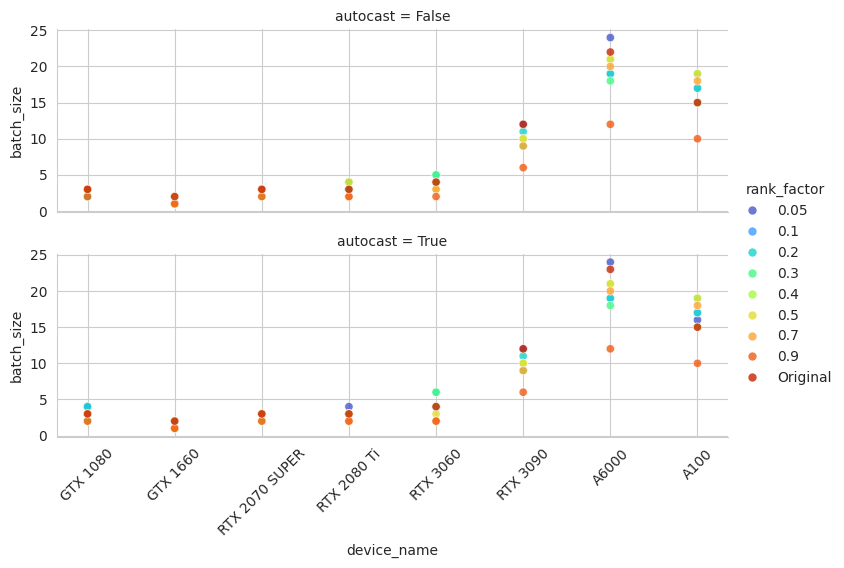

In [4]:
g = sns.relplot(
    data=df_batch,
    x='device_name',
    y='batch_size',
    hue='rank_factor',
    row='autocast',
    palette='turbo',
    alpha=0.8,
    height=2.5,
    aspect=3,
)

plt.xticks(rotation=45)
plt.show()

### Execution times

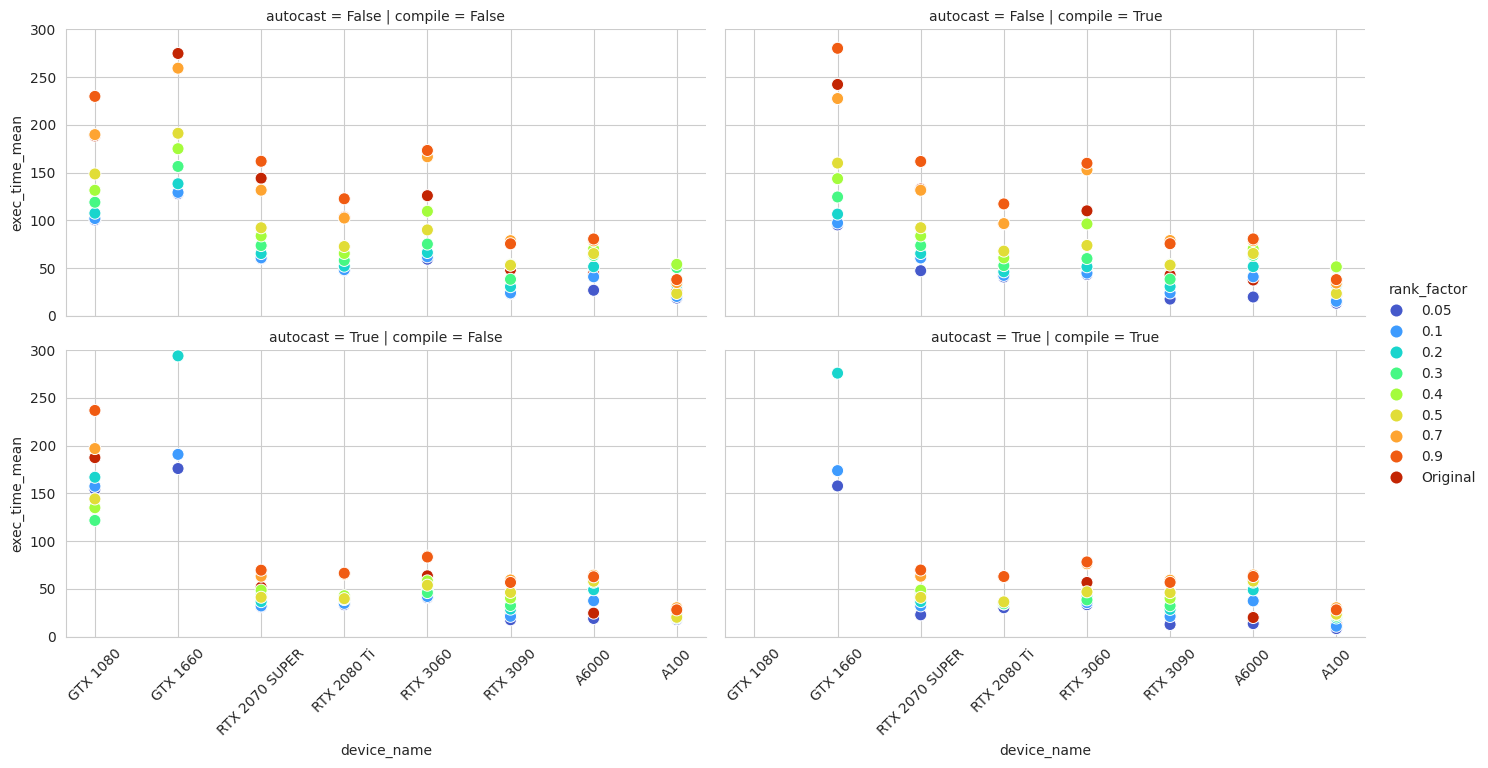

In [11]:
df_sub = df[df['batch_size'] == 1]

g = sns.relplot(
    data=df_sub,
    x='device_name',
    y='exec_time_mean',
    hue='rank_factor',
     row='autocast',
    col='compile',
    palette='turbo',
    alpha=1,
    height=3.5,
    aspect=2,
    s=75
)

g.set(ylim=(0, 300))

for ax in g.axes.flatten():
    ax.set_xticks(range(len(new_order)))
    ax.set_xticklabels(labels=new_order, rotation=45)
    
plt.show()